In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [25]:
df = pd.read_csv('/content/drive/MyDrive/dataDEEPPcleaned.csv')
df_genre_year = df.groupby(['Genre', 'Year'])['Global_Sales'].sum().reset_index()


In [26]:
features = []
for genre in df_genre_year['Genre'].unique():
    subset = df_genre_year[df_genre_year['Genre'] == genre].sort_values('Year')
    total_sales = np.log1p(subset['Global_Sales'].sum())       # log-transform
    mean_sales = np.log1p(subset['Global_Sales'].mean())       # log-transform
    std_sales = subset['Global_Sales'].std()
    slope = LinearRegression().fit(
        subset['Year'].values.reshape(-1, 1),
        subset['Global_Sales'].values
    ).coef_[0]
    features.append({
        'Genre': genre,
        'Total_Sales_log': total_sales,
        'Mean_Sales_log': mean_sales,
        'Std_Sales': std_sales,
        'Sales_Slope': slope
    })

df_features = pd.DataFrame(features).set_index('Genre')


In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)


In [28]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_features['Cluster'] = kmeans.fit_predict(scaled_features)


In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Genre'] = df_features.index
df_pca['Cluster'] = df_features['Cluster']


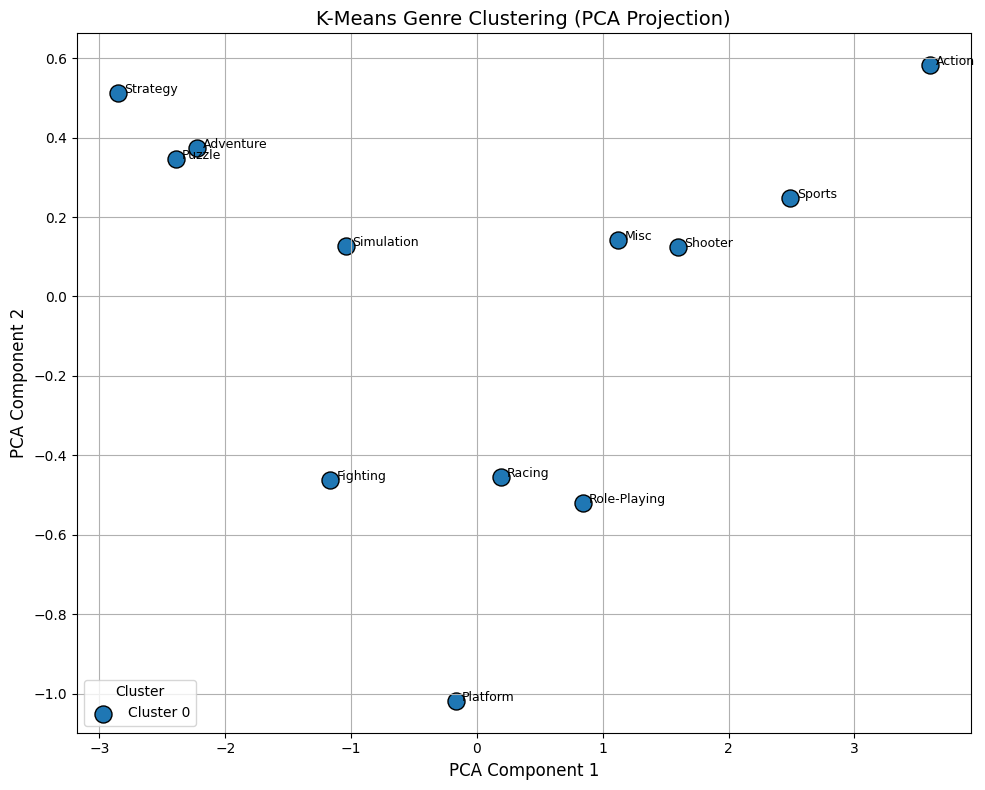

In [30]:
# Pastikan Cluster adalah integer
df_pca['Cluster'] = df_pca['Cluster'].fillna(0).astype(int) # Fill NaN with 0 before conversion

# Buat visualisasi
plt.figure(figsize=(10, 8))
# Tentukan warna untuk setiap cluster
cluster_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

# Loop setiap cluster agar bisa dikendalikan warnanya
for cluster in sorted(df_pca['Cluster'].unique()):
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        s=150,
        edgecolor='black',
        label=f'Cluster {cluster}',
        color=cluster_colors[cluster]  # Gunakan warna yang telah ditentukan
    )
    for _, row in cluster_data.iterrows():
        plt.text(row['PC1'] + 0.05, row['PC2'], row['Genre'], fontsize=9)

plt.title("K-Means Genre Clustering (PCA Projection)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-31-413c76829b9a>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(brand_sales.index, color='white')
<ipython-input-31-413c76829b9a>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), color='white')


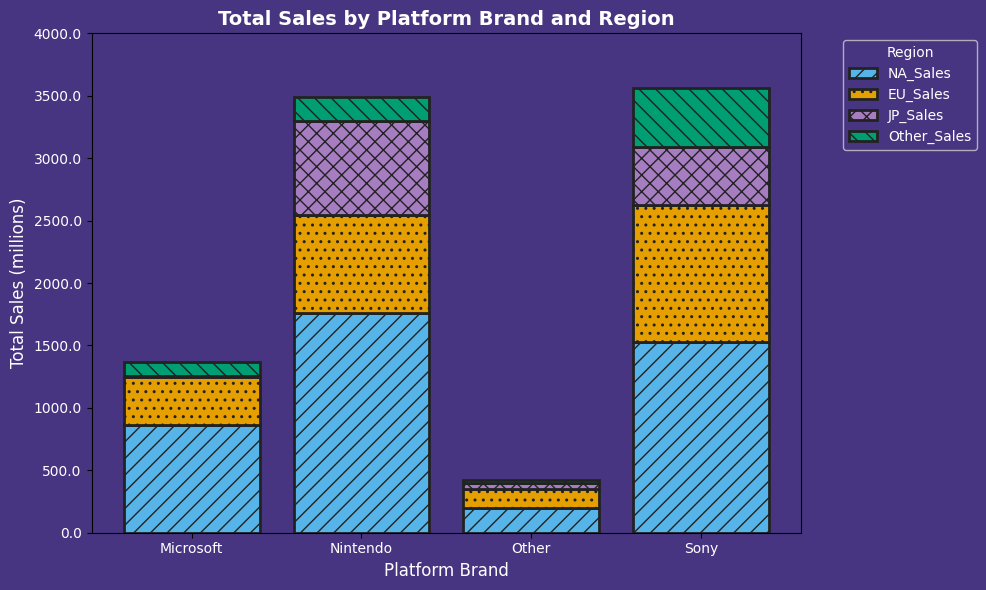

In [31]:
# Agregasi sales per platform
platform_sales = df.groupby('Platform')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()

# Klasifikasi brand
def classify_brand(platform):
    if platform in ['Wii', 'WiiU', 'DS', '3DS', 'GB', 'GBA', 'SNES', 'NES', 'N64', 'GC', 'Switch']:
        return 'Nintendo'
    elif platform in ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV']:
        return 'Sony'
    elif platform in ['X360', 'XB', 'XOne', 'XSX']:
        return 'Microsoft'
    else:
        return 'Other'

platform_sales['Brand'] = platform_sales['Platform'].apply(classify_brand)

# Hitung total per brand
brand_sales = platform_sales.groupby('Brand')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()


colors = ['#56B4E9', '#E69F00', '#A77DC2', '#009E73']  # biru cerah, oranye, ungu muda, hijau cerah
hatches = ['//', '..', 'xx', '\\\\']

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#473581')
ax.set_facecolor('#473581')

bottom = np.zeros(len(brand_sales.index))

for i, region in enumerate(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']):
    ax.bar(
        brand_sales.index,
        brand_sales[region],
        bottom=bottom,
        color=colors[i],
        hatch=hatches[i],
        edgecolor='#222222',
        label=region,
        linewidth=2
    )
    bottom += brand_sales[region].values

ax.set_title('Total Sales by Platform Brand and Region', fontsize=14, color='white', fontweight='bold')
ax.set_xlabel('Platform Brand', fontsize=12, color='white')
ax.set_ylabel('Total Sales (millions)', fontsize=12, color='white')
ax.set_xticklabels(brand_sales.index, color='white')
ax.set_yticklabels(ax.get_yticks(), color='white')
ax.set_yticks(range(0, 4001, 500))

leg = ax.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(leg.get_texts(), color='white')
plt.setp(leg.get_title(), color='white')
leg.get_frame().set_facecolor('#473581')

ax.grid(False)
plt.tight_layout()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

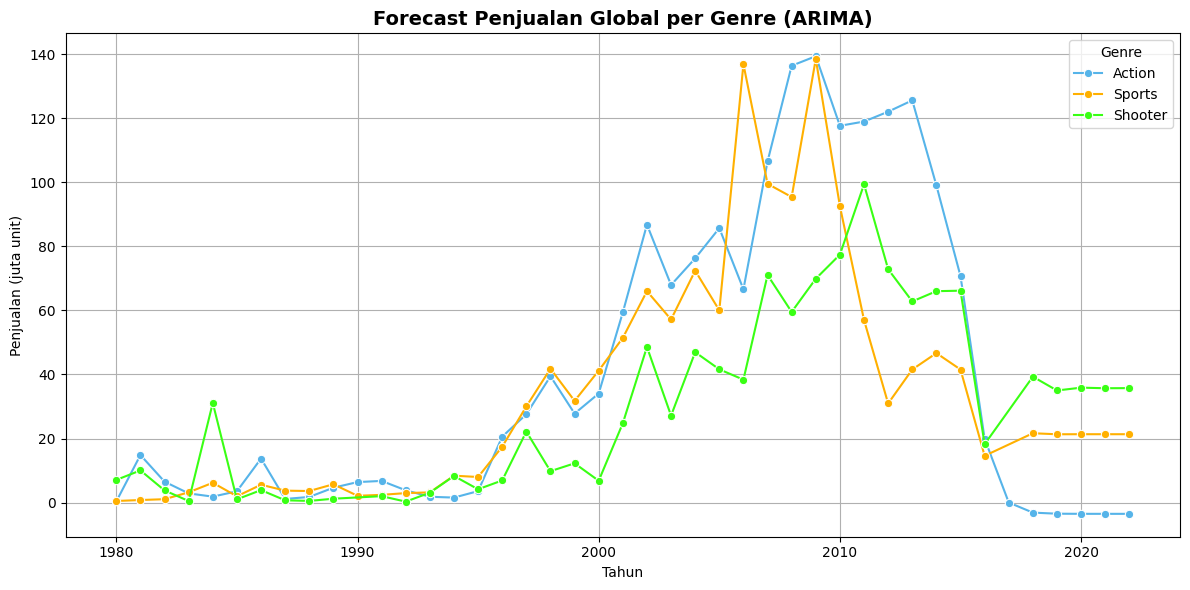

In [32]:
import statsmodels.api as sm

# Ambil genre dengan total sales tertinggi
top_3_genres = df_genre_year.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(3).index

# Buat forecast per genre dengan ARIMA(1,1,1)
forecast_years = list(range(df_genre_year['Year'].max() + 1, df_genre_year['Year'].max() + 6))
forecast_df = []

for genre in top_3_genres:
    genre_df = df_genre_year[df_genre_year['Genre'] == genre].set_index('Year')['Global_Sales']
    model = sm.tsa.ARIMA(genre_df, order=(1,1,1))
    fitted = model.fit()
    pred = fitted.forecast(steps=5)

    for year, value in zip(forecast_years, pred):
        forecast_df.append({'Genre': genre, 'Year': year, 'Forecast_Sales': value})

    # Gabungkan dengan historis untuk visualisasi
    for year, value in genre_df.items():
        forecast_df.append({'Genre': genre, 'Year': year, 'Forecast_Sales': value})

df_arima_forecast = pd.DataFrame(forecast_df)

# Visualisasi hasil
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_arima_forecast, x='Year', y='Forecast_Sales', hue='Genre', marker='o')
plt.title('Forecast Penjualan Global per Genre (ARIMA)', fontsize=14, weight='bold')
plt.xlabel('Tahun')
plt.ylabel('Penjualan (juta unit)')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

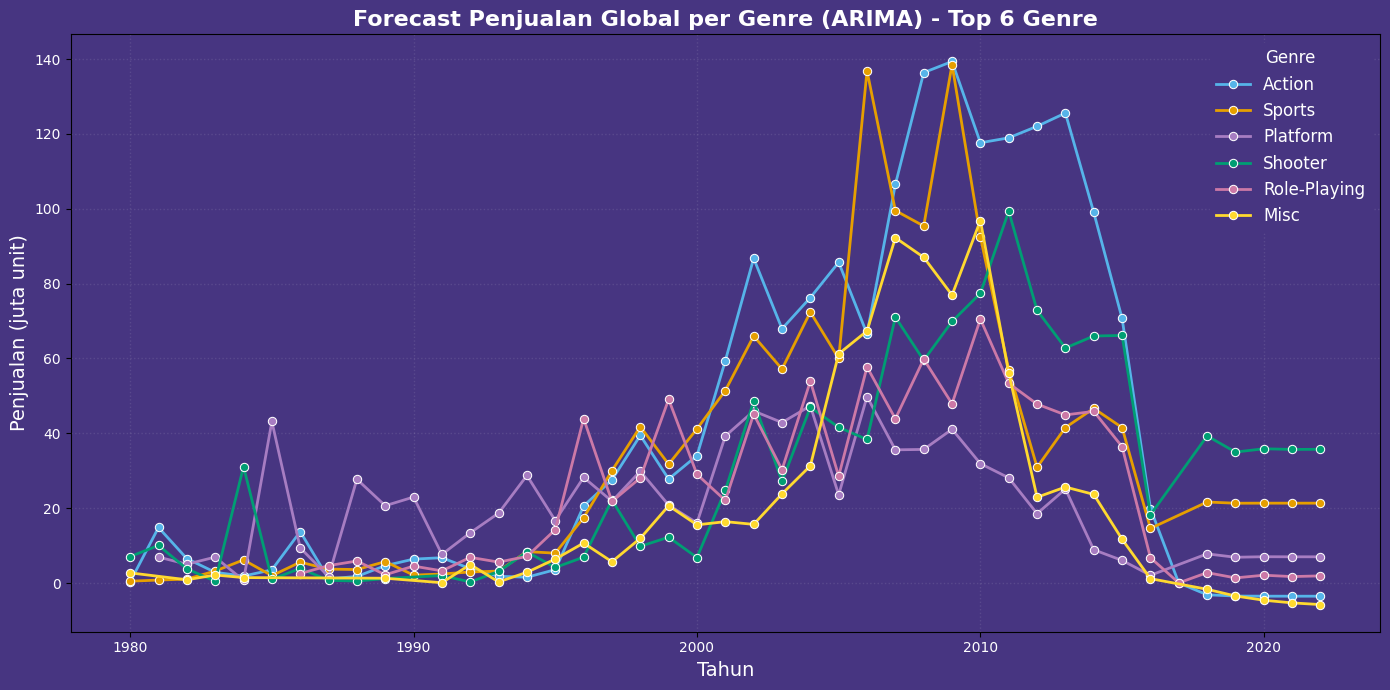

In [38]:
# Ulangi forecast ARIMA untuk semua genre dengan data historis minimal 5 tahun
forecast_all = []

# Ambil genre valid
all_valid_genres = df_genre_year['Genre'].value_counts()
all_valid_genres = all_valid_genres[all_valid_genres >= 5].index.tolist()

for genre in all_valid_genres:
    genre_df = df_genre_year[df_genre_year['Genre'] == genre].set_index('Year')['Global_Sales']
    try:
        model = sm.tsa.ARIMA(genre_df, order=(1, 1, 1))
        fitted = model.fit()
        pred = fitted.forecast(steps=5)

        for year, value in zip(forecast_years, pred):
            forecast_all.append({'Genre': genre, 'Year': year, 'Forecast_Sales': value})

        # Tambahkan data historis
        for year, value in genre_df.items():
            forecast_all.append({'Genre': genre, 'Year': year, 'Forecast_Sales': value})
    except:
        continue  # Lewati jika error

df_arima_all = pd.DataFrame(forecast_all)

# Visualisasikan semua genre (top 6 saja agar tidak terlalu padat)
top_genres_arima = df_arima_all.groupby('Genre')['Forecast_Sales'].sum().sort_values(ascending=False).head(6).index
df_arima_top6 = df_arima_all[df_arima_all['Genre'].isin(top_genres_arima)]

plt.figure(figsize=(14, 7))

# Custom palette colorblind-friendly, soft but kontras
palette = ['#56B4E9', '#E69F00', '#A77DC2', '#009E73', '#CC79A7', '#FFD92F']  # 6 warna berbeda
sns.set_palette(sns.color_palette(palette))

ax = plt.gca()
fig = plt.gcf()
fig.patch.set_facecolor('#473581')
ax.set_facecolor('#473581')

# Plot
sns.lineplot(
    data=df_arima_top6,
    x='Year',
    y='Forecast_Sales',
    hue='Genre',
    marker='o',
    linewidth=2,
    ax=ax
)

plt.title('Forecast Penjualan Global per Genre (ARIMA) - Top 6 Genre',
          fontsize=16, weight='bold', color='white')
plt.xlabel('Tahun', color='white', fontsize=14)
plt.ylabel('Penjualan (juta unit)', color='white', fontsize=14)

plt.xticks(color='white')
plt.yticks(color='white')

# Gridlines putih tipis atau hilangkan jika ingin super clean
ax.grid(True, color='white', linestyle=':', alpha=0.10, linewidth=1)

# Legend putih
leg = plt.legend(title='Genre', fontsize=12, title_fontsize=12, facecolor='#473581', framealpha=1)
plt.setp(leg.get_texts(), color='white')
plt.setp(leg.get_title(), color='white')
leg.get_frame().set_edgecolor('#473581')

plt.tight_layout()
plt.show()
